# Wave (.wav) to Zero Crossing.

This is an attempt to produce synthetic ZC (Zero Crossing) from FS (Full Scan) files. All parts are calculated in the time domain to mimic true ZC. FFT is not used (maybe with the exception of the internal implementation of the Butterworth filter).

Current status: Seems to work well for "easy files", but not for mixed and low amplitude recordings. I don't know why...

The resulting plot is both embedded in this notebook and as separate files: 'zc_in_time_domain_test_1.png' and 'zc_in_time_domain_test_2.png'.

Sources in information/inspiration:

- http://users.lmi.net/corben/fileform.htm#Anabat%20File%20Formats
- https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
- https://github.com/riggsd/zcant/blob/master/zcant/conversion.py


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import scipy.io.wavfile as wf
import scipy.signal
#import sounddevice

In [2]:
# Settings.
#sound_file = '../data_in/Mdau_TE384.wav'
sound_file = '../data_in/Ppip_TE384.wav'
#sound_file = '../data_in/Myotis-Plecotus-Eptesicus_TE384.wav'

cutoff_freq_hz = 18000
zc_divratio = 4 

In [3]:
# Debug settings.
play_sound = False
debug = False

In [4]:
# Read the sound file.
(sampling_freq, signal_int16) = wf.read(sound_file, 'rb')
print('Sampling freq in file: ' + str(sampling_freq) + ' Hz.')
print(str(len(signal_int16)) + ' samples.')
#if play_sound:
#    sounddevice.play(signal_int16, sampling_freq)
#    sounddevice.wait()

Sampling freq in file: 38400 Hz.
586452 samples.


In [5]:
# Check if TE, Time Expansion.
if '_TE' in sound_file:
    sampling_freq *= 10
print('Sampling freq: ' + str(sampling_freq) + ' Hz.')

Sampling freq: 384000 Hz.


In [6]:
# Signed int16 to [-1.0, 1.0].
signal = np.array(signal_int16) / 32768 

In [7]:
# Noise level. RMS, root-mean-square.
noise_level = np.sqrt(np.mean(np.square(signal)))
print(noise_level)

0.016186364861810285


In [8]:
# Filter. Butterworth.
nyquist = 0.5 * sampling_freq
low = cutoff_freq_hz / nyquist
filter_order = 9
b, a = scipy.signal.butter(filter_order, [low], btype='highpass')
#signal= scipy.signal.lfilter(b, a, signal)
signal= scipy.signal.filtfilt(b, a, signal)

In [9]:
# Add hysteresis around zero to remove noise.
signal[(signal < noise_level) & (signal > -noise_level)] = 0.0

In [10]:
# Check where zero crossings may occur.
sign_diff_array = np.diff(np.sign(signal))

In [11]:
# Extract positive zero passings and interpolate where it occurs.
index_array = []
old_index = None
for index, value in enumerate(sign_diff_array):
    if value in [2., 1., 0.]:
        # Check for raising signal level.
        if value == 2.:
            # From negative directly to positive. Calculate interpolated index.
            x_adjust = signal[index] / (signal[index] - signal[index+1])
            index_array.append(index + x_adjust)
            old_index = None
        elif (value == 1.) and (old_index is None):
            # From negative to zero.
            old_index = index
        elif (value == 1.) and (old_index is not None):
            # From zero to positive. Calculate interpolated index.
            x_adjust = signal[old_index] / (signal[old_index] - signal[index+1])
            index_array.append(old_index + x_adjust)
            old_index = None      
    else:
        # Falling signal level.
        old_index = None

print(len(index_array))
if debug:
    print(index_array[:100])

3944


In [12]:
zero_crossings = index_array[::zc_divratio]
print(len(zero_crossings))

986


In [13]:
# Prepare lists.
freqs = []
times = []
for index, zero_crossing in enumerate(zero_crossings[0:-1]):
    freq = zero_crossings[index+1] - zero_crossings[index]
    freq_hz = sampling_freq * zc_divratio / freq
    if freq_hz >= cutoff_freq_hz:
        freqs.append(freq_hz)
        times.append(zero_crossing)
print(len(freqs))

929


In [14]:
# Prepare arrays for plotting.
freq_array_khz = np.array(freqs) / 1000.0
time_array_s = np.array(times) / sampling_freq
time_array_compact = range(0, len(times))
if debug:
    print(len(freq_array_khz))
    print(freq_array_khz[:100])
    print(time_array_s[:100])

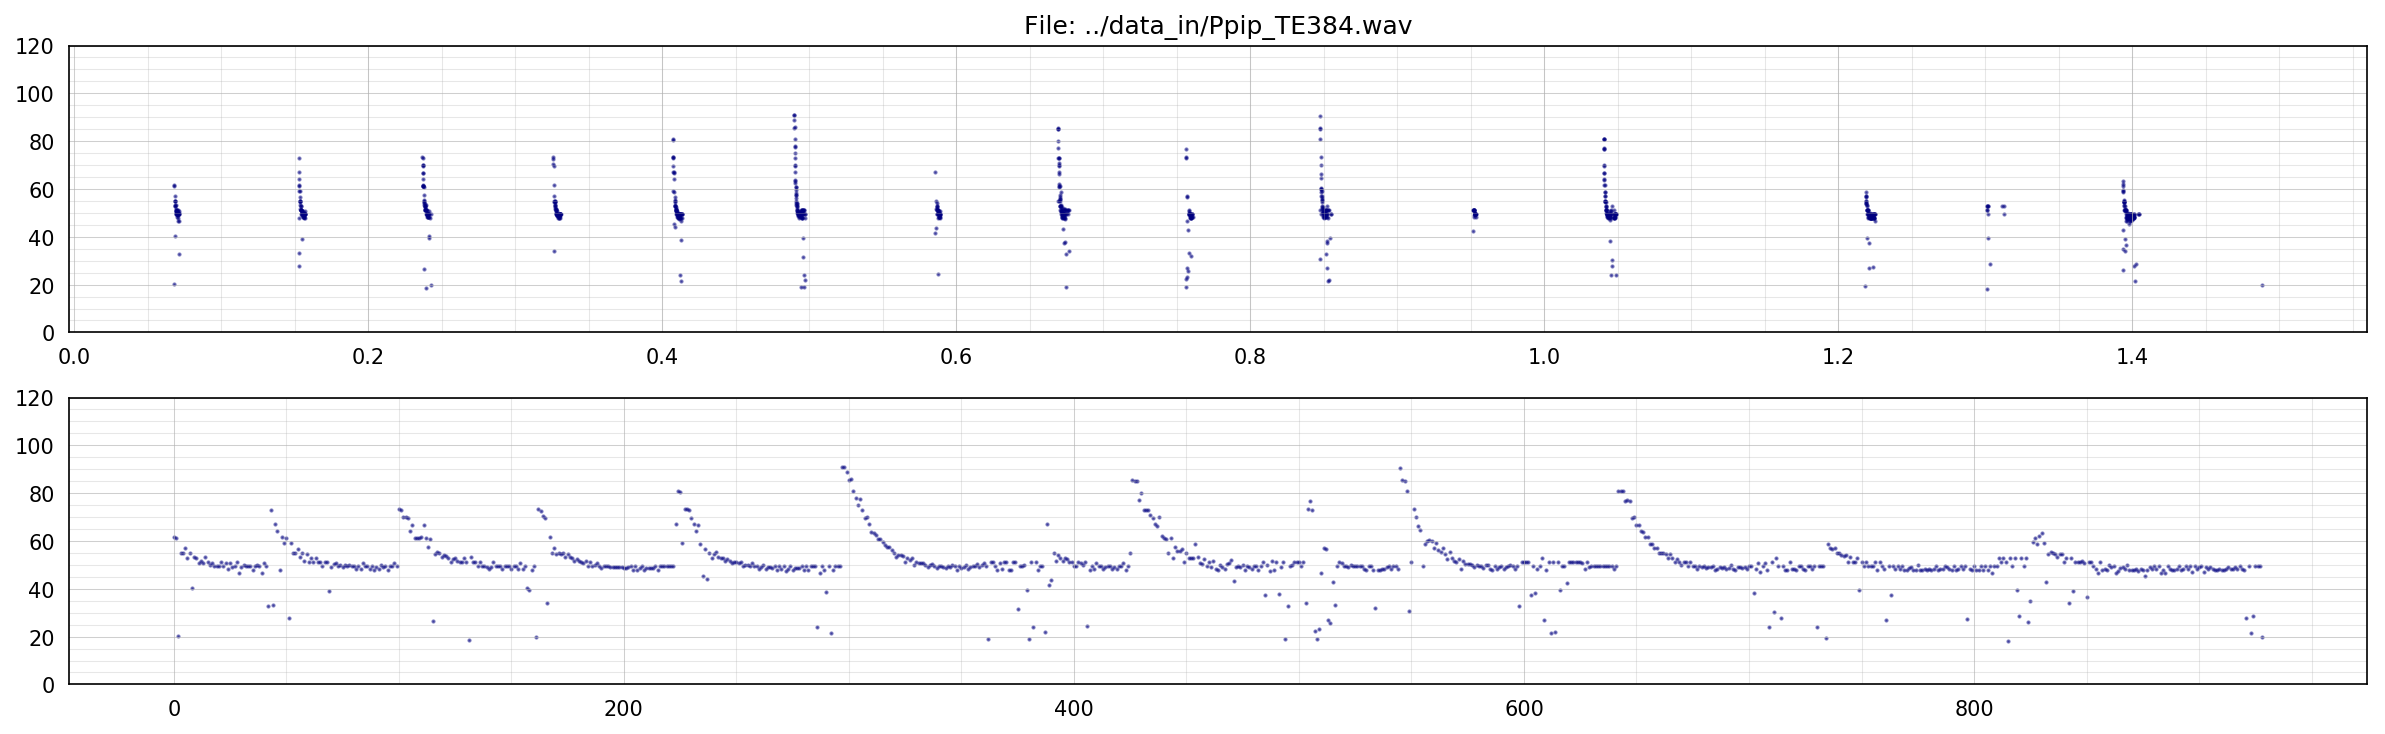

In [15]:
# Plot two diagrams, normal and compressed time.
fig, (ax1, ax2) = plt.subplots(2,1,
                       figsize=(16, 5), 
                       dpi=150, 
                       #facecolor='w', 
                       #edgecolor='k',
                              )
# ax1.
ax1.scatter(time_array_s, freq_array_khz, s=1, c='navy', alpha=0.5)

ax1.set_title('File: ' + sound_file)
ax1.set_ylim((0,120))
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
ax1.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
ax1.tick_params(which='both', top='off', left='off', right='off', bottom='off') 
# ax2.
ax2.scatter(time_array_compact, freq_array_khz, s=1, c='navy', alpha=0.5)

ax2.set_ylim((0,120))
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.6)
ax2.grid(which='minor', linestyle='-', linewidth='0.5', alpha=0.3)
ax2.tick_params(which='both', top='off', left='off', right='off', bottom='off') 

plt.tight_layout()
fig.savefig('zc_in_time_domain_test.png')
#fig.savefig('zc_in_time_domain_test_1.png')
#fig.savefig('zc_in_time_domain_test_2.png')
plt.show()